In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from helpers import sql

# pandas formatting
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', 200)
pd.set_option('display.float_format', '{:.0f}'.format)

In [2]:
all_steps = [
    # 'created_at',
    'submission_date',
    
    'date_chair_sent', 
    'date_chair_appr', 
    'date_coordinator_sent', 
    'date_coordinator_appr', 
    'date_section_head_appr', 
    'date_section_head_sent', 
    'date_division_manager_appr', 
    'date_division_manager_sent', 
    'date_director_sent',
    'date_director_appr', 
    'date_translation_sent', 
    'date_returned', 
    'translation_review_date', 
    'date_doc_submitted', 
    # 'date_proof_author_sent', 
    # 'date_proof_author_approved', 
    # 'pub_number_assigned_date', 
    'actual_posting_date', 
]

columns = ['document_id', 'sector_name', 'title_en',  'title_fr'] + all_steps

df = sql("""
    SELECT 
        csas2_document.id AS document_id, 
        shared_models_sector.name AS sector_name,
        title_en, title_fr,
        csas2_document.created_at AS created_at,
        csas2_documenttracking.submission_date AS submission_date, 
        
        date_chair_sent, 
        date_chair_appr, 
        date_coordinator_sent, 
        date_coordinator_appr, 
        date_division_manager_appr, 
        date_division_manager_sent, 
        date_section_head_appr, 
        date_section_head_sent, 
        date_director_sent,
        date_director_appr, 
        date_translation_sent, 
        translation_review_date, 
        date_doc_submitted, 
        date_proof_author_sent, 
        date_proof_author_approved, 
        date_returned, 
        pub_number_assigned_date, 
        actual_posting_date 
        
    FROM csas2_document
        JOIN csas2_documenttracking ON csas2_document.id = csas2_documenttracking.document_id    
        JOIN csas2_process ON csas2_document.process_id = csas2_process.id
        JOIN csas2_process_csas_requests ON csas2_process.id = csas2_process_csas_requests.process_id
        JOIN csas2_csasrequest ON csas2_process_csas_requests.csasrequest_id = csas2_csasrequest.id
        JOIN shared_models_section ON shared_models_section.id = csas2_csasrequest.section_id
        JOIN shared_models_division ON shared_models_division.id = shared_models_section.division_id
        JOIN shared_models_branch ON shared_models_branch.id = shared_models_division.branch_id
        JOIN shared_models_sector ON shared_models_sector.id = shared_models_branch.sector_id
    WHERE document_type_id = 2;
""")[columns]

df['pub_time'] = df['actual_posting_date'] - df['submission_date']
df['pub_time'] = df['pub_time'].dt.days
df['is_fsar'] = df.sector_name.str.contains("Fisheries & Harbour Management", na=False)

df_sar = df[~df.sector_name.str.contains("Fisheries & Harbour Management", na=False)].copy()
df_fsar = df[df.sector_name.str.contains("Fisheries & Harbour Management", na=False)].copy()

In [3]:
percentiles = [0.1, 0.5, 0.9]

summary_all = df[['pub_time']].describe(percentiles=percentiles).T
summary_all.index = ['All SAR with dates']

summary_false = df[~df.is_fsar][['pub_time']].describe(percentiles=percentiles).T
summary_false.index = ['Not FSAR']

summary_true = df[df.is_fsar][['pub_time']].describe(percentiles=percentiles).T
summary_true.index = ['FSAR (likely)']

summary_all.insert(1, 'out of total:', df.shape[0])
summary_false.insert(1, 'out of total:', df[~df.is_fsar].shape[0])
summary_true.insert(1, 'out of total:', df[df.is_fsar].shape[0])

summary_all.insert(2, '==============', '================')
summary_false.insert(2, '==============', '================')
summary_true.insert(2, '==============', '================')

summary = pd.concat([summary_all, summary_false, summary_true]).T

print("\nDays from Initial Submission to Publication")
display(summary)


Days from Initial Submission to Publication


,All SAR with dates,Not FSAR,FSAR (likely)
count,85,18,67
out of total:,359,235,124
==============,================,================,================
mean,118,176,103
std,115,209,67
min,32,51,32
10%,54,60,54
50%,92,112,88
90%,171,334,156
max,940,940,512


In [4]:
def time_matrix(dataframe, col_lst, all_stats=False, quantile=0.5):
    df_temp = dataframe[col_lst].copy()
    for col in col_lst:
        df_temp[col] = pd.to_datetime(df_temp[col], errors='coerce')
    matrix = pd.DataFrame(index=col_lst, columns=col_lst)
    
    for i, from_step in enumerate(col_lst):
        for j, to_step in enumerate(col_lst):
            if i < j:
                if all_stats:
                    matrix.loc[from_step, to_step] = (
                        round((df_temp[to_step] - df_temp[from_step]).dt.days.mean(), 1),
                        round((df_temp[to_step] - df_temp[from_step]).dt.days.quantile([0.025, 0.16, 0.5, 0.84, 0.975]), 1),
                    )
                else:
                    matrix.loc[from_step, to_step] = round((df_temp[to_step] - df_temp[from_step]).dt.days.quantile(quantile), 1)
                
    return matrix.apply(pd.to_numeric, errors='coerce').dropna(how='all').dropna(how='all', axis=1)


def diagonal(dataframe, col_lst, name, quantile=0.5):
    matrix = time_matrix(dataframe, col_lst, quantile=quantile)
    diagonal_values = matrix.values.diagonal()
    labels = [f"{matrix.index[i]} > {matrix.columns[i]}" for i in range(len(diagonal_values))]
    return pd.Series(diagonal_values, index=labels, name=name)


def plot_heatmap(dataframe, col_lst, quantile=0.5, figsize=(8, 8)):
    plt.figure(figsize=figsize)
    
    matrix = time_matrix(dataframe, col_lst, quantile=quantile).fillna(-99)
    annot = matrix.map(lambda x: f"{int(x)}" if x >= 0 else "")
    
    fig = sns.heatmap(
        matrix, 
        annot=annot, 
        cmap='Blues',
        vmin=-10,
        vmax=100,
        fmt='', 
        cbar=False
    )
    
    fig.xaxis.set_ticks_position('top')
    fig.tick_params(axis='x', rotation=90, length=0)
    fig.tick_params(axis='x', rotation=90)
    
    plt.show()
    

def print_all(quantile=0.5):
    print("\nCombined FSAR and SAR")
    plot_heatmap(df, all_steps, quantile=quantile)
    print("\nSAR")
    plot_heatmap(df_sar, all_steps, quantile=quantile)
    print("\nFSAR")
    plot_heatmap(df_fsar, all_steps, quantile=quantile)


10%ile

Combined FSAR and SAR


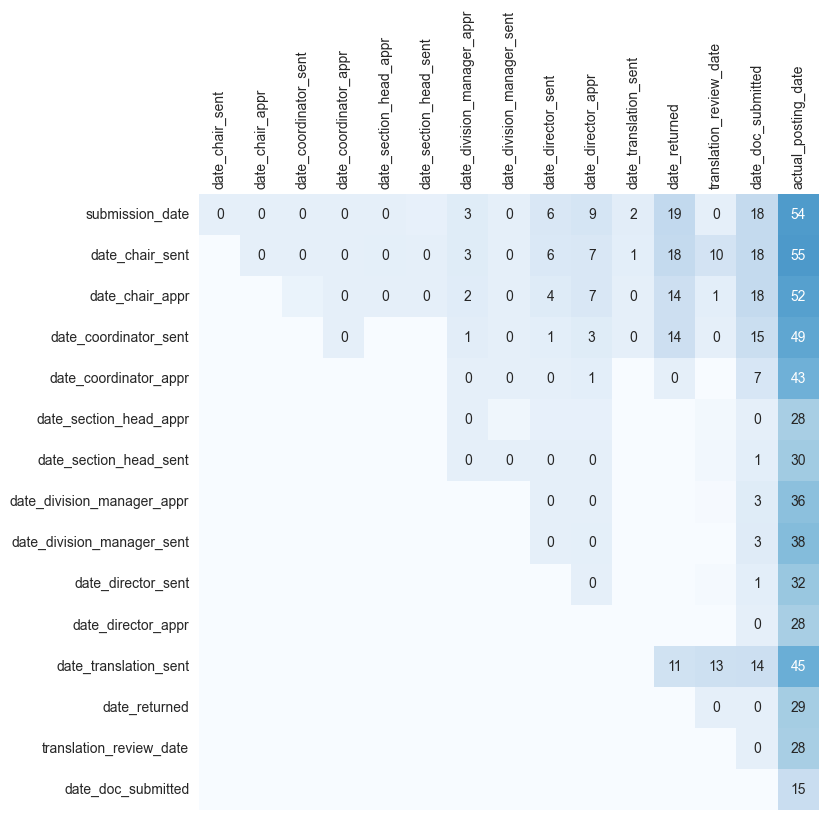


SAR


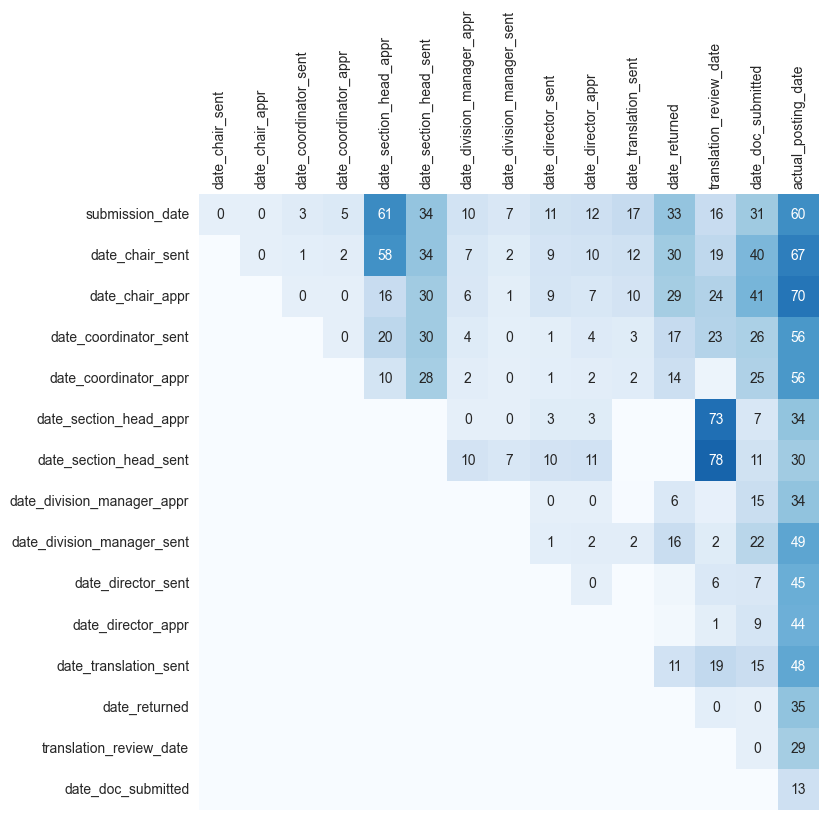


FSAR


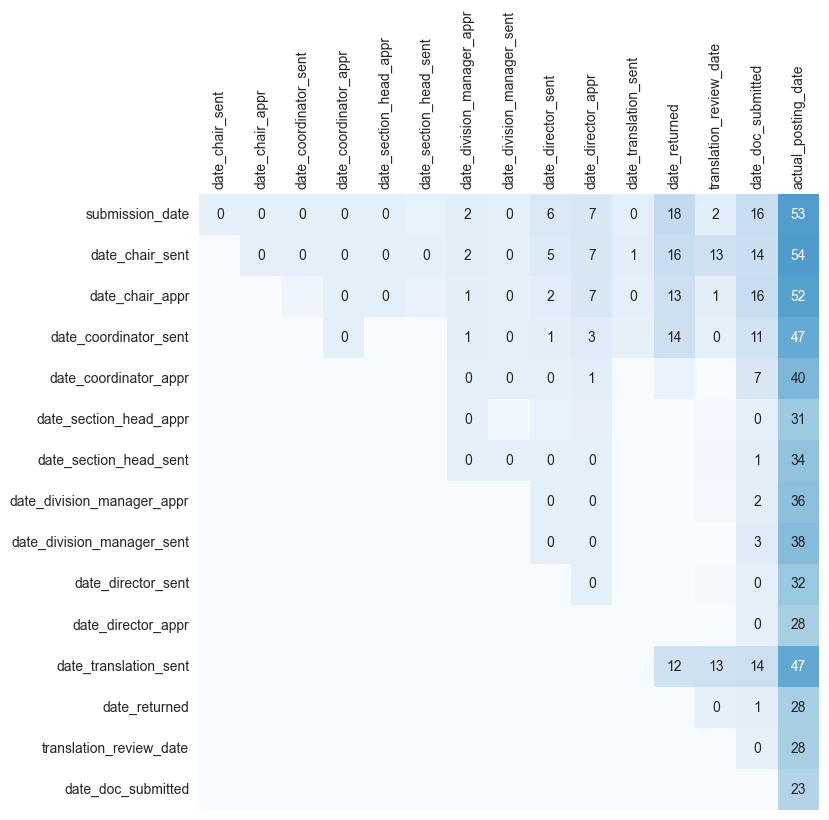


50%ile

Combined FSAR and SAR


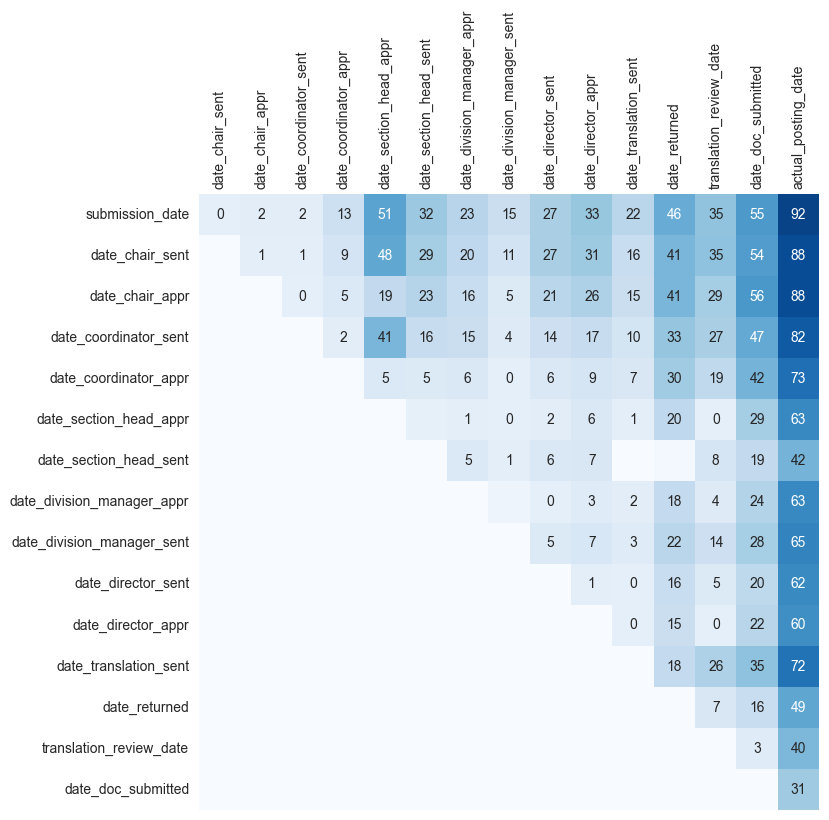


SAR


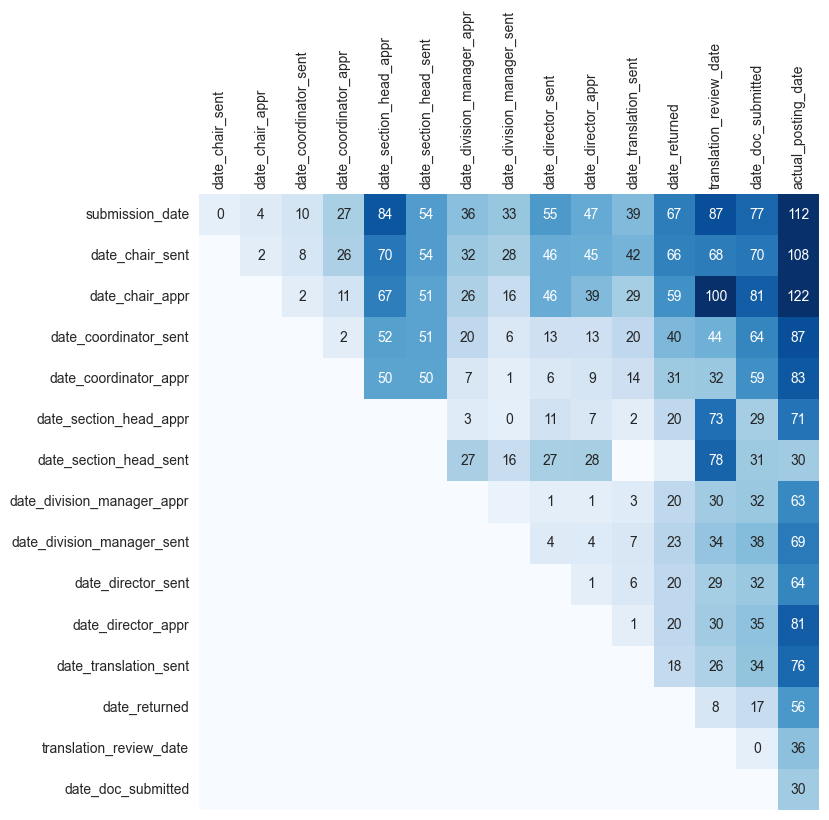


FSAR


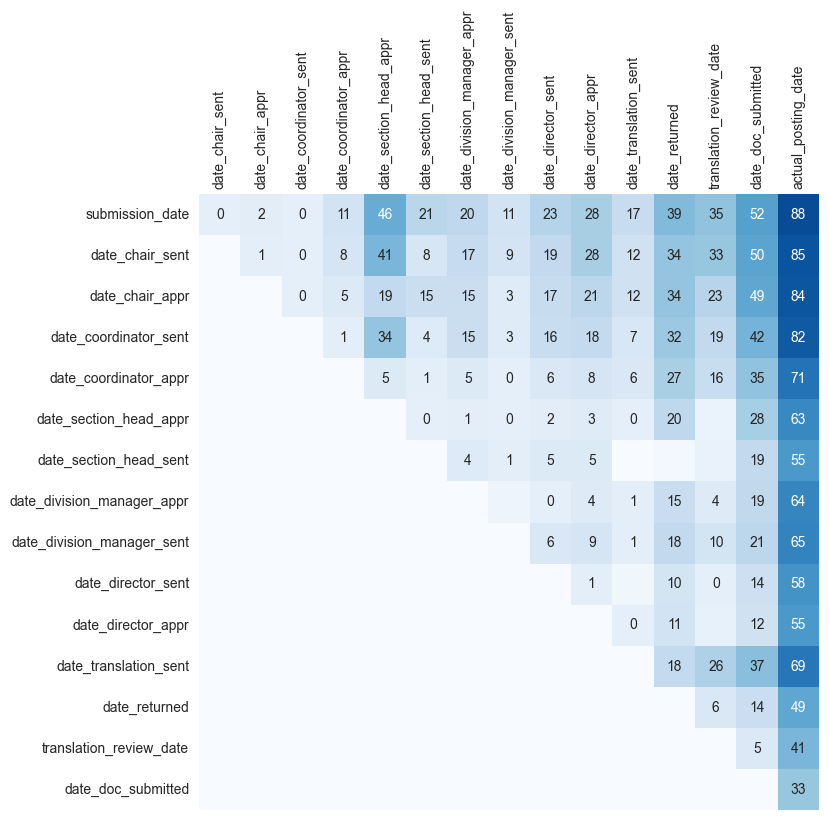


90%ile

Combined FSAR and SAR


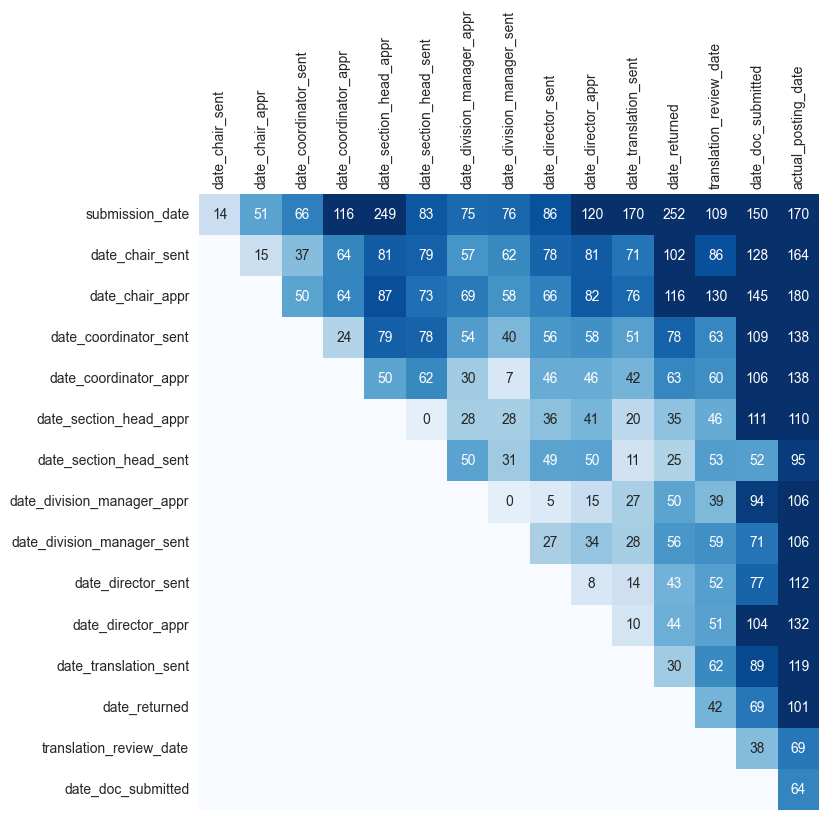


SAR


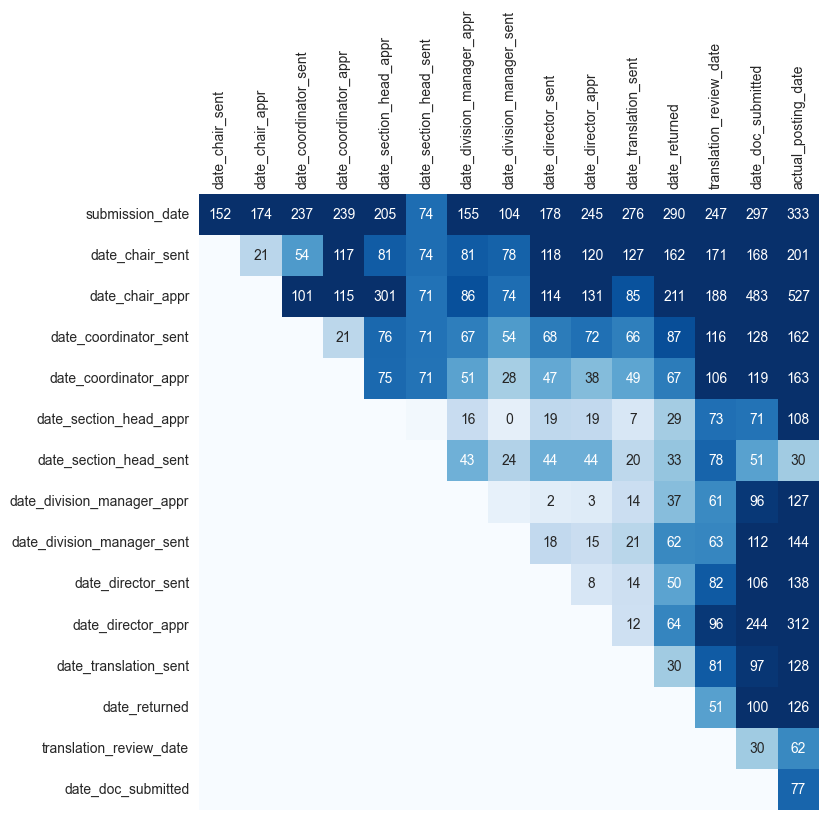


FSAR


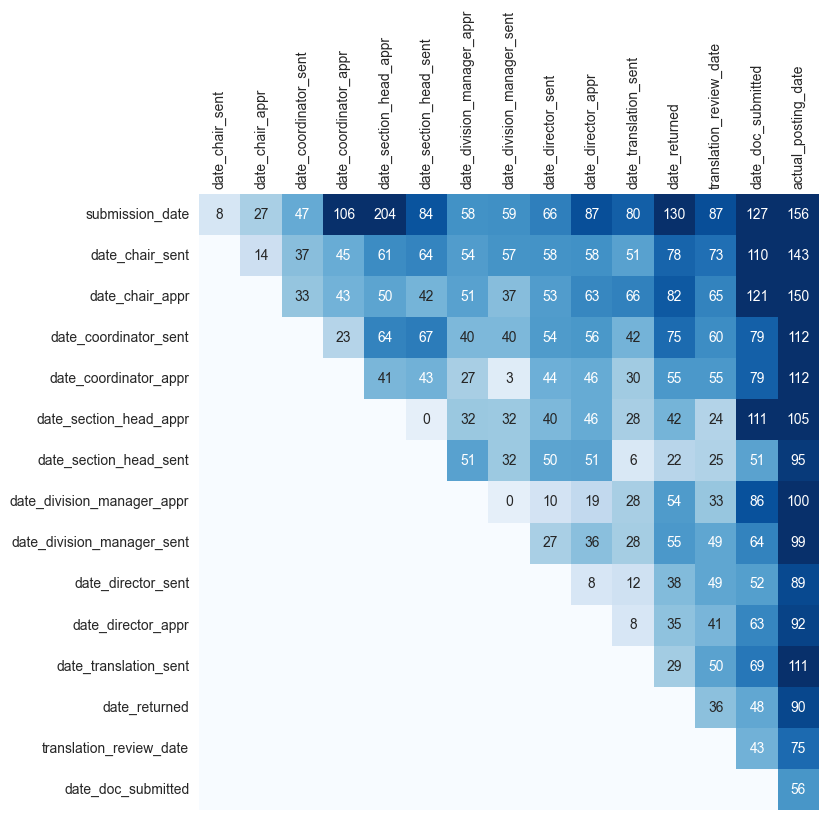

In [5]:
for q in [0.1, 0.5, 0.9]:
    print(f"\n{q:.0%}ile\n==========================")
    print_all(q)